In [ ]:
import os
import sys

import torch

import numpy as np
import pandas as pd

import nibabel as nib

import matplotlib.pyplot as plt
import torchio as tio

In [ ]:
def split_train_test(df, split_ratio=0.8):
    datasets = df.Dataset.unique()
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for dataset in datasets:
        dataset_df = df[df['Dataset'] == dataset]
        dataset_df = dataset_df.sample(frac=1).reset_index(drop=True) # shuffle
        train_df = pd.concat([train_df, dataset_df.iloc[:int(len(dataset_df)*split_ratio)]])
        test_df = pd.concat([test_df, dataset_df.iloc[int(len(dataset_df)*split_ratio):]])

    train_df['mode'] = 'train'
    test_df['mode'] = 'val'
    print(f"Total: {len(train_df)+len(test_df)} || Train Sample: {len(train_df)}, Test Sample: {len(test_df)}")
    merge_df = pd.concat([train_df, test_df], axis=0)

    return merge_df

## Final EDA

In [ ]:
long_df = pd.read_csv('/NFS/FutureBrainGen/data/long/long_old_HC_subj_phenotype_splited.csv')
long_df.rename({"SubID":"Subject"}, inplace=True, axis=1)
long_df.describe()

In [ ]:
long_df['mode'].value_counts()

In [ ]:
long_df.info()

In [ ]:
cross_df = pd.read_csv('/NFS/FutureBrainGen/data/cross/cross_old_subj_phenotype_splited.csv')
cross_df.describe()

In [ ]:
cross_df.info()

## EDA for Cross Sectional data

In [ ]:
cross_df = pd.read_csv('/NFS/FutureBrainGen/data/cross/CrossSectional_included_file_v2.csv')
hc_cross_df = cross_df[cross_df['Group'] == 'HC']
hc_cross_df = hc_cross_df[hc_cross_df['Dataset'] != 'BGSP']
hc_cross_df = hc_cross_df[hc_cross_df['Dataset'] != 'BNU']
hc_cross_df = hc_cross_df[hc_cross_df['Dataset'] != 'RBP-L1']
hc_cross_df = hc_cross_df[hc_cross_df['Age'] >= 40]
hc_cross_df

In [ ]:
hc_cross_df.Dataset.value_counts()

In [ ]:
plt.hist(hc_cross_df['Age'], bins=10)
plt.show()

In [ ]:
splited_hc_cross_df = split_train_test(hc_cross_df, 0.85)
splited_hc_cross_df

In [ ]:
# hc_cross_df.to_csv("/NFS/FutureBrainGen/data/cross/cross_old_subj_phenotype.csv", index=False)
# splited_hc_cross_df.to_csv("/NFS/FutureBrainGen/data/cross/cross_old_subj_phenotype_splited.csv", index=False)

## Longitudinal EDA

In [ ]:
long_df = pd.read_csv('/NFS/FutureBrainGen/data/long/long_phenotype_v2_clean_group.csv', index_col=0)
hc_long_df = long_df[(long_df['Group_B'] == 'HC') & (long_df['Group_F'] == 'HC')]
old_hc_long_df = hc_long_df[hc_long_df['Age_B'] >= 40]
old_hc_long_df.head(3)

In [ ]:
splited_old_hc_long_df = split_train_test(old_hc_long_df, 0.94)
splited2_old_hc_long_df = split_train_test(splited_old_hc_long_df[splited_old_hc_long_df['mode']=='train'], 0.94)
splited2_old_hc_long_df_test = splited_old_hc_long_df[splited_old_hc_long_df['mode']=='val']
splited2_old_hc_long_df_test['mode']='test'

In [ ]:
splited2_old_hc_long_df = pd.concat([splited2_old_hc_long_df, splited2_old_hc_long_df_test], axis=0)
splited2_old_hc_long_df

In [ ]:
# splited2_old_hc_long_df.to_csv("/NFS/FutureBrainGen/data/long/long_old_HC_subj_phenotype_splited.csv", index=False)

In [ ]:
plt.hist(old_hc_long_df['Age_B'], bins=10, alpha=0.7, color='navy', label='Baseline')
plt.hist(old_hc_long_df['Age_F'], bins=10, alpha=0.7, color='orange', label='Follow-up')
plt.text(85, 410, f"Total Session: {len(old_hc_long_df)}", fontsize=8)
plt.legend()
plt.show()

In [ ]:
plt.bar(np.arange(1, 11, 1), old_hc_long_df['Interval'].value_counts().sort_index(),
        edgecolor='black', color='skyblue', label='Interval')
plt.xticks(np.arange(1, 11, 1))
plt.legend()
plt.show()

## Crop Image

In [ ]:
MRIPATH = '/NFS/FutureBrainGen/data/long/down_img_1.7mm/'
PHENO = '/NFS/FutureBrainGen/data/cross/CrossSectional_included_file.csv'
MRILIST = os.listdir(MRIPATH)

temp = MRILIST

In [ ]:
img = nib.load(MRIPATH + temp[0])
img = img.get_fdata()

# Convert the numpy array to a PyTorch tensor
img_data = torch.from_numpy(img).float()
img_data = img_data.unsqueeze(0)

# Get the original dimensions (assumed to be 3D data)
d, h, w = img_data.shape[1:]  # Shape without the channel

# Define the target crop size
target_d, target_h, target_w = (96, 112, 96)

# Calculate the start and end indices for cropping (crop from the center)
start_d = (d - target_d) // 2
start_h = (h - target_h) // 2
start_w = (w - target_w) // 2

img_data = img_data[:, start_d:start_d + target_d, start_h:start_h + target_h, start_w:start_w + target_w]

In [ ]:
print("Original Image Shape: ", img.shape)
print("Cropped Image Shape: ", img_data[0].shape)
print(target_d//2, target_h//2, target_w//2)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img_data[0, :, :, target_d//2])
ax[1].imshow(img_data[0, target_h//2, :, :])
ax[2].imshow(img_data[0, :, target_d//2, :])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

## VQ-GAN

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [50]:
def viz_image(img):
    origin = img['origin']
    recon = img['recon']
    if type(origin) == torch.Tensor:
        origin = origin.cpu().detach().numpy()
        
    fig, ax = plt.subplots(2, 3, figsize=(8, 5))
    ax[0, 0].imshow(origin[0][ :, :,53], cmap='gray')
    ax[0, 1].imshow(np.rot90(origin[0][ :, 48, :]), cmap='gray')
    ax[0, 2].imshow(np.rot90(origin[0][ 48, :, :]), cmap='gray')
    ax[1, 0].imshow(recon[0][ :, :, 53], cmap='gray')
    ax[1, 1].imshow(np.rot90(recon[0][ :, 48, :]), cmap='gray')
    ax[1, 2].imshow(np.rot90(recon[0][ 48, :, :]), cmap='gray')

    for i in range(2):
        for j in range(3):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.tight_layout()
    plt.show()

In [51]:
model = 'VQGAN'
wandb_id = 'dry-night-3' # 'floral-field-2'
dim=16

# img = np.load(f'/NFS/FutureBrainGen/results/{model}/img/{wandb_id}/img.npy')

epoch = [400, 500]

Epoch: 400


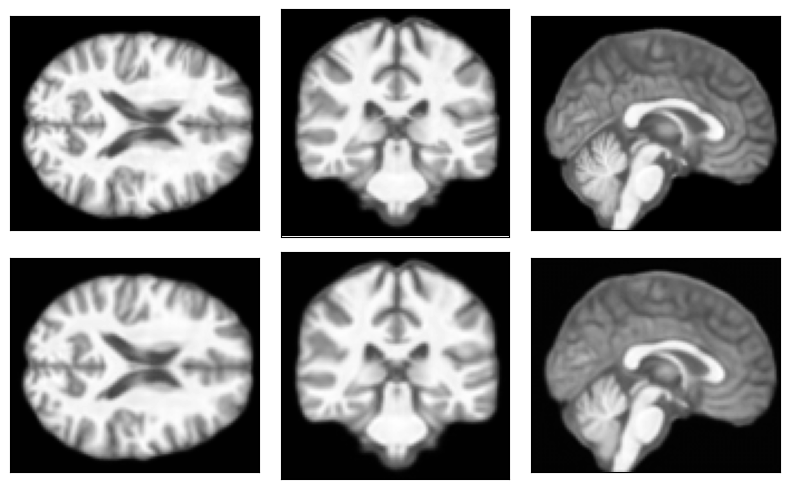

Epoch: 500


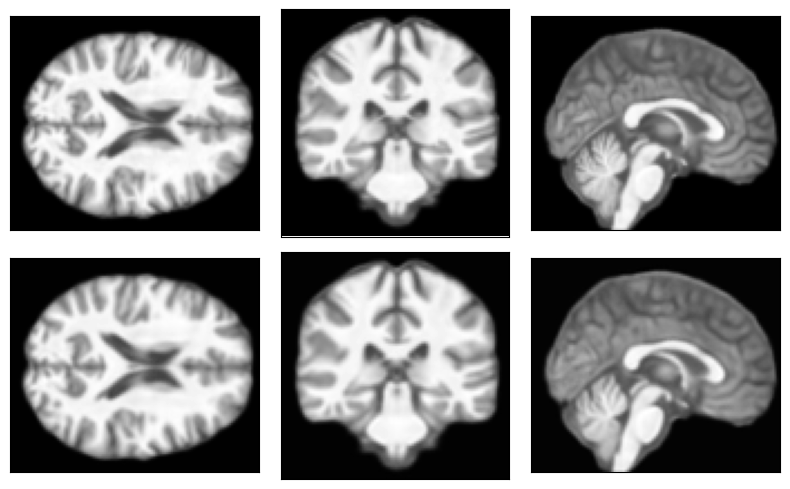

In [52]:
for e in epoch:
    print(f"Epoch: {e}")
    img = np.load(f'/NFS/FutureBrainGen/results/{model}/img/{wandb_id}/recon_ep{e}_0_dim{dim}.npz')
    viz_image(img)

## LDM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
def viz_ldm_image(img, img_idx=0):

    base, origin, recon, Age_B, Age_F, Sex = img['base_img'], img['follow_img'], img['synthetic_images'], img['Age_B'], img['Age_F'], img['Sex']

    base = base.cpu().detach().numpy()
    origin = origin.cpu().detach().numpy()
    recon = recon.cpu().detach().numpy()
        
    fig, ax = plt.subplots(3, 3)


    ax[0, 0].imshow(base[img_idx].squeeze()[:, :, 48], cmap='gray')
    ax[0, 1].imshow(np.rot90(base[img_idx].squeeze()[:, 48, :]), cmap='gray')
    ax[0, 2].imshow(np.rot90(base[img_idx].squeeze()[48, :, :]), cmap='gray')

    ax[1, 0].imshow(origin[img_idx].squeeze()[:, :, 48], cmap='gray')
    ax[1, 1].imshow(np.rot90(origin[img_idx].squeeze()[:, 48, :]), cmap='gray')
    ax[1, 2].imshow(np.rot90(origin[img_idx].squeeze()[48, :, :]), cmap='gray')

    ax[2, 0].imshow(recon[img_idx].squeeze()[:, :, 48], cmap='gray')
    ax[2, 1].imshow(np.rot90(recon[img_idx].squeeze()[:, 48, :]), cmap='gray')
    ax[2, 2].imshow(np.rot90(recon[img_idx].squeeze()[48, :, :]), cmap='gray')

    ax[0,0].set_title(f"(Base) Age: {Age_B[img_idx]} // Sex {Sex[img_idx]}", fontsize=8)
    ax[1,0].set_title(f"(FU) Age: {Age_F[img_idx]} // Sex {Sex[img_idx]}", fontsize=8)
    ax[2,0].set_title(f"(Recon) Age: {Age_F[img_idx]} // Sex {Sex[img_idx]}", fontsize=8)

    for i in range(3):
        for j in range(3):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
model ='LDM'
wandb_id = 'olive-deluge-4'
epochs = [1]

In [ ]:
for e in epochs:
    img = torch.load(f'/NFS/FutureBrainGen/results/{model}/img/{wandb_id}/{model}_ep{e}_dim16_{wandb_id}.pth')
    viz_ldm_image(img, img_idx=0)
    viz_ldm_image(img, img_idx=1)